# GTN

## 0. Paper

### Info
* Title: Generative Teaching Networks: Accelerating Neural Architecture Search by Learning to Generate Synthetic Training Data
* Author: Felipe Petroski Such
* Task: Neural Architecture Search
* Link: https://arxiv.org/abs/1912.07768


### Features
* Dataset: MNIST
* Weight Normalization: X
* NAS: X

### Reference
* https://github.com/GoodAI/GTN


## 1. Setting

In [ ]:
!pip install -q higher

In [ ]:
import os
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import higher

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [ ]:
class CONFIG:
    batch_size = 128
    epoch_size = 300
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset = 'MNIST'
    base_dir = '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'

## 2. Data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CONFIG.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=CONFIG.batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
x, y = next(iter(train_loader))
x.size(), y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## 3. Model

In [ ]:
class Teacher(nn.Module):
    def __init__(self, device):
        super(Teacher, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(512 + 10, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 32*7*7)
        self.bn2 = nn.BatchNorm1d(32*7*7)
        self.conv1 = nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)


    def forward(self, z, y):
        x = torch.cat([z, y], dim=1)
        x = F.leaky_relu(self.bn1(self.fc1(x)), 0.1)
        x = F.leaky_relu(self.bn2(self.fc2(x)), 0.1)
        x = x.view(-1, 32, 7, 7)

        x = F.leaky_relu(self.bn3(self.conv1(x)))
        x = F.leaky_relu(self.bn4(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        return x

    def generate_data(self, size=320):
        y = torch.randint(low=0, high=10, size=(size,)).to(self.device)
        y_onehot = F.one_hot(y, num_classes=10).float()
        z = torch.normal(0.0, 1.0, (size, 512)).to(self.device)
        x = self(z, y_onehot)
        return x, y



class Learner(nn.Module):
    def __init__(self):
        super(Learner, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(64*7*7, 10)

    def reset(self):
        def init_weight(m):
            if type(m) in [nn.Conv2d, nn.Linear]:
                torch.nn.init.xavier_normal_(m.weight)
        self.apply(init_weight)
    
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        x = self.pool1(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## 4. Experiment

In [ ]:
class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.3f}'
        return fmtstr


class ProgressMeter(object):
    def __init__(self, meters):
        self.meters = [AverageMeter(m) for m in meters]
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def log(self):
        msg = [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)
        return msg


def accuracy(logits, targets):
    _, preds = logits.max(1)
    acc = (preds == targets).float().mean()
    return acc

In [ ]:
class Trainer(object):
    def __init__(self, teacher, learner, optimizer, device):
        self.teacher = teacher.to(device)
        self.learner = learner.to(device)
        self.optimizer = optimizer
        self.device = device
        self.train_inner_step = 10
        self.test_inner_step = 100
        self.steps_per_epoch = 100
        self.best_epoch, self.best_score = 0, 0
        

    def train(self, train_loader, epoch):
        progress = ProgressMeter(["inner_loss", "inner_acc", "outer_loss", "outer_acc"])
        self.teacher.train()
        self.learner.train()

        pbar = tqdm(range(self.steps_per_epoch))
        pbar.set_description(f'TRAIN {epoch:03d}')
        for idx in pbar:
            self.learner.reset()
            learner_optim = torch.optim.Adam(self.learner.parameters())
            inner_loss, inner_acc = 0, 0
            
            with higher.innerloop_ctx(self.learner, learner_optim) as (flearner, diffopt):
                for step in range(self.train_inner_step):
                    teacher_inputs, teacher_targets = self.teacher.generate_data(train_loader.batch_size)
                    learner_logits = flearner(teacher_inputs)
                    _inner_loss = F.cross_entropy(learner_logits, teacher_targets) 
                    diffopt.step(_inner_loss)
                    inner_loss += _inner_loss.item()
                    inner_acc += accuracy(learner_logits, teacher_targets).item()

            inner_loss /= self.train_inner_step
            inner_acc /= self.train_inner_step

            real_inputs, real_targets = next(iter(train_loader))
            real_inputs, real_targets = real_inputs.to(self.device), real_targets.to(self.device)
            learner_logits = flearner(real_inputs)
            outer_loss = F.cross_entropy(learner_logits, real_targets)

            self.optimizer.zero_grad()
            outer_loss.backward()
            self.optimizer.step()
            outer_loss = outer_loss.item()
            outer_acc = accuracy(learner_logits, real_targets).item()
            progress.update([inner_loss, inner_acc, outer_loss, outer_acc], n=real_inputs.size(0))
            pbar.set_postfix(log=progress.log())

        teacher_inputs, teacher_targets = self.teacher.generate_data(train_loader.batch_size)
        teacher_inputs = torchvision.utils.make_grid(teacher_inputs, normalize=True)
        torchvision.utils.save_image(teacher_inputs, f'results/{epoch:03d}.png')

    
    def test(self, test_loader, epoch):
        progress = ProgressMeter(["test_loss", "test_acc"])
        self.teacher.eval()
        self.learner.train()
        self.learner.reset()
        learner_optimizer = torch.optim.Adam(self.learner.parameters())

        for step in range(self.test_inner_step):
            teacher_inputs, teacher_targets = self.teacher.generate_data(test_loader.batch_size)
            learner_logits = self.learner(teacher_inputs)
            inner_loss = F.cross_entropy(learner_logits, teacher_targets)

            learner_optimizer.zero_grad()
            inner_loss.backward()
            learner_optimizer.step()

        self.learner.eval()
        pbar = tqdm(test_loader)
        pbar.set_description(f'TEST  {epoch:03d}')
        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.learner(inputs)
                loss = F.cross_entropy(outputs, targets)
                loss = loss.item()
                acc = accuracy(outputs, targets).item()
                progress.update([loss, acc], n=inputs.size(0))
                pbar.set_postfix(log=progress.log())

In [ ]:
!mkdir results

In [ ]:
teacher = Teacher(CONFIG.device)
learner = Learner()
optimizer = torch.optim.Adam(teacher.parameters())

In [ ]:
trainer = Trainer(teacher, learner, optimizer, CONFIG.device)

In [ ]:
for ep in range(CONFIG.epoch_size):
    print('=' * 100)
    trainer.train(train_loader, ep)
    trainer.test(test_loader, ep)

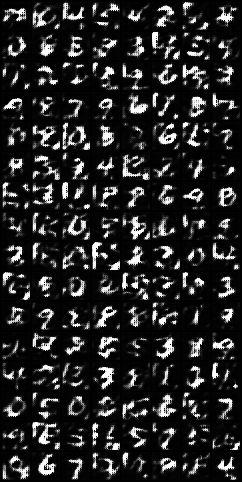

In [ ]:
Image.open('results/299.png')

### Comparsion with Vanilla Learning

In [ ]:
learner = Learner()
learner.to(CONFIG.device)

optimizer = torch.optim.Adam(learner.parameters())
train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

learner.train()
for _ in range(100):
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(CONFIG.device), targets.to(CONFIG.device)
    outputs = learner(inputs)
    loss = F.cross_entropy(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy(outputs, targets).item()


learner.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(CONFIG.device), targets.to(CONFIG.device)
    outputs = learner(inputs)
    loss = F.cross_entropy(outputs, targets)
    test_loss += loss.item()
    test_acc += accuracy(outputs, targets).item()


train_loss /= 100
train_acc /= 100
test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Vanilla Learning | Train Loss {train_loss:.3f} | Train Acc {train_acc:.3f} | Test Loss {test_loss:.3f} | Test Acc {test_acc:.3f}')

Vanilla Learning | Train Loss 0.368 | Train Acc 0.890 | Test Loss 0.116 | Test Acc 0.965
